In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt

from model import lorenz63_fdm
from assimilation import OI, ExtendedKF, EnKF, M3DVar

In [2]:
X_nature = np.load('./data/X_nature.npy')
X_ini = np.load('./data/X_ini.npy')
ts = np.load('./data/time_span.npy')
Pb = np.load('./data/Pb.npy')
R = np.load('./data/R.npy')

In [3]:
dt = 0.01

In [5]:
def RMSE(forecast, nature):
    return np.sqrt(np.mean((forecast-nature)**2, axis=0))

# Assimilate normal observation

#### `rmse_oi` as CNTL in the later experiments

In [6]:
# normal observation
X_obs = np.load('./data/obs_normal.npy')

In [11]:
oi = OI(lorenz63_fdm, dt)
oi.list_params()
params = {
    'X_ini': X_ini,
    'obs': X_obs,
    'obs_interv': 8,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
    'H': np.eye(3)
}
oi.set_params(**params)
oi.cycle()

0.9437468879169666


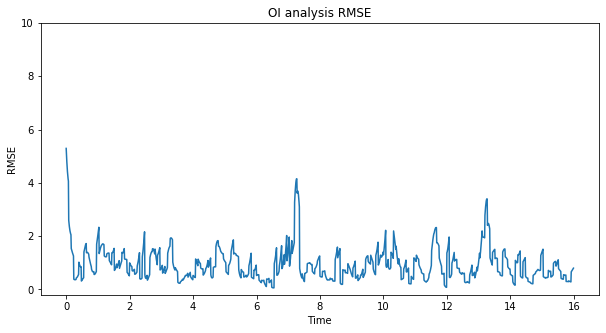

In [14]:
rmse_oi = RMSE(oi.analysis, X_nature)

plt.figure(figsize=(10, 5))
plt.plot(ts, rmse_oi)
plt.xlabel('Time')
plt.ylabel('RMSE')
plt.ylim([-0.2, 10])
plt.title('OI analysis RMSE')
print(rmse_oi.mean())

# First moment

### Assimilate bias observations based on normality test

In [15]:
# first moment
ex_obs_dict = pickle.load(open('./data/obs_bias_005_040.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.05', '0.15', '0.20', '0.25', '0.30', '0.35', '0.40'])

obsm=0.05, Mean RMSE=0.9080, Variance RMSE=0.2854,  Without spinup: Mean RMSE=0.8826, Variance RMSE=0.2302
obsm=0.15, Mean RMSE=0.9892, Variance RMSE=0.3226,  Without spinup: Mean RMSE=0.9590, Variance RMSE=0.2574
obsm=0.20, Mean RMSE=0.9547, Variance RMSE=0.4264,  Without spinup: Mean RMSE=0.9267, Variance RMSE=0.3348
obsm=0.25, Mean RMSE=0.9658, Variance RMSE=0.3425,  Without spinup: Mean RMSE=0.9431, Variance RMSE=0.2768
obsm=0.30, Mean RMSE=1.0157, Variance RMSE=0.4008,  Without spinup: Mean RMSE=0.9825, Variance RMSE=0.3140
obsm=0.35, Mean RMSE=1.0816, Variance RMSE=0.4314,  Without spinup: Mean RMSE=1.0571, Variance RMSE=0.3530
obsm=0.40, Mean RMSE=1.0908, Variance RMSE=0.5736,  Without spinup: Mean RMSE=1.0699, Variance RMSE=0.5286


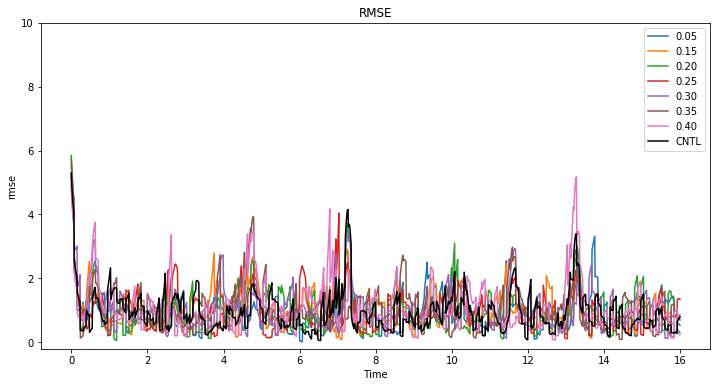

In [17]:
plt.figure(figsize=(12, 6))

mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

for obsm in ex_obs_dict.keys():
    obs = ex_obs_dict[obsm]

    params = {
        'X_ini': X_ini,
        'obs': obs,
        'obs_interv': 8,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
        'H': np.eye(3)
    }
    oi = OI(lorenz63_fdm, dt)
    oi.set_params(**params)
    oi.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(oi.analysis, X_nature)
    print(
        f'obsm={obsm}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=obsm)
    
plt.plot(ts, rmse_oi, 'k', label='CNTL')
plt.legend()
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse')
plt.ylim([-0.2, 10]);

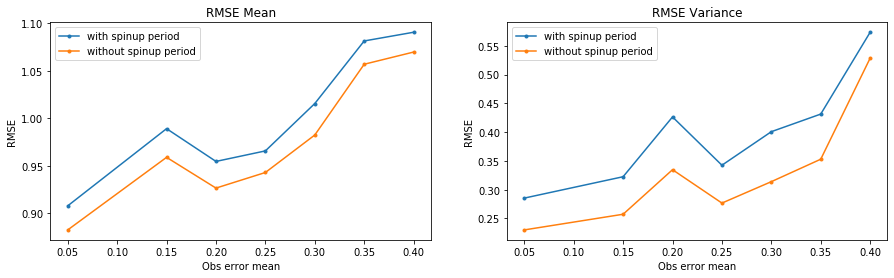

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_mean = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_mean, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_mean, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_mean, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_mean, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

### Assimilate more extreme bias observations

In [19]:
ex_obs_dict = pickle.load(open('./data/obs_bias_020_520.pickle', 'rb'))

obsm=0.20, Mean RMSE=1.0056, Variance RMSE=0.3929,  Without spinup: Mean RMSE=0.9781, Variance RMSE=0.3278
obsm=0.45, Mean RMSE=1.1088, Variance RMSE=0.5301,  Without spinup: Mean RMSE=1.0807, Variance RMSE=0.4682
obsm=0.70, Mean RMSE=1.3117, Variance RMSE=0.5716,  Without spinup: Mean RMSE=1.2849, Variance RMSE=0.5262
obsm=0.95, Mean RMSE=1.3674, Variance RMSE=0.6316,  Without spinup: Mean RMSE=1.3501, Variance RMSE=0.5686
obsm=1.20, Mean RMSE=1.5968, Variance RMSE=0.8505,  Without spinup: Mean RMSE=1.5770, Variance RMSE=0.7963
obsm=1.45, Mean RMSE=1.8038, Variance RMSE=0.5541,  Without spinup: Mean RMSE=1.7778, Variance RMSE=0.4728
obsm=1.70, Mean RMSE=2.1045, Variance RMSE=0.8225,  Without spinup: Mean RMSE=2.0643, Variance RMSE=0.7525
obsm=1.95, Mean RMSE=2.4525, Variance RMSE=1.3605,  Without spinup: Mean RMSE=2.3799, Variance RMSE=1.1982
obsm=2.20, Mean RMSE=2.4949, Variance RMSE=1.1673,  Without spinup: Mean RMSE=2.4472, Variance RMSE=1.0707
obsm=2.45, Mean RMSE=2.7156, Variance

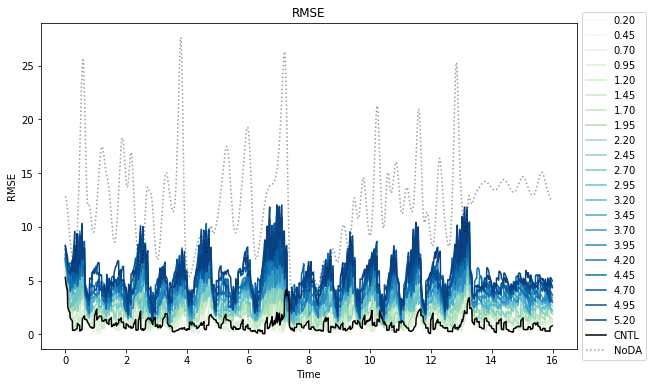

In [21]:
import matplotlib.cm as cm


mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))
colors = cm.GnBu(np.linspace(0, 1, len(ex_obs_dict.keys())))

for obsm, color in zip(ex_obs_dict.keys(), colors):
    obs = ex_obs_dict[obsm]

    params = {
        'X_ini': X_ini, 
        'obs': obs, 
        'obs_interv': 8,
        'Pb': Pb,
        'R': R, 
        'H_func': lambda arr: arr,
        'H': np.eye(3)
    }

    oi = OI(lorenz63_fdm, dt)
    oi.set_params(**params)
    oi.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(oi.analysis, X_nature)
    print(
        f'obsm={obsm}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())
    
    plt.plot(ts, rmse, color=color, label=obsm)
    
# CNTL
plt.plot(ts, rmse_oi, color='k', label='CNTL')

# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('RMSE');

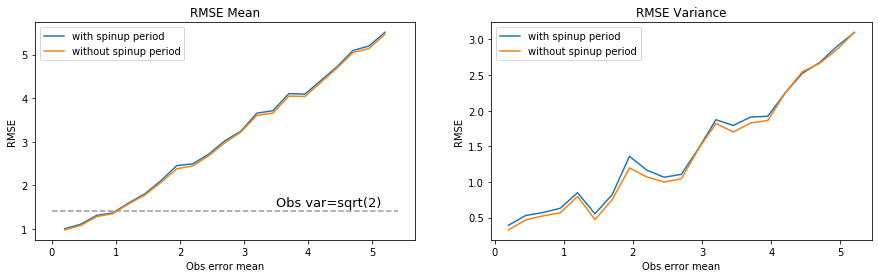

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_mean = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_mean, mean_rmse, label='with spinup period')
axs[0].plot(ex_mean, mean_rmse_nospn, label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')
axs[0].hlines(y=np.sqrt(2), xmin=0, xmax=5.4, ls='dashed', alpha=0.4)
axs[0].text(3.5, np.sqrt(2)+0.1, 'Obs var=sqrt(2)', fontsize=13)

axs[1].plot(ex_mean, var_rmse, label='with spinup period')
axs[1].plot(ex_mean, var_rmse_nospn, label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

# Third moment

### Assimilate skew observation based on normality test

In [24]:
ex_obs_dict = pickle.load(open('./data/obs_skew_015_135.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.15', '0.45', '0.75', '1.05', '1.35'])

alpha=0.15, Mean RMSE=0.9920, Variance RMSE=0.3641,  Without spinup: Mean RMSE=0.9753, Variance RMSE=0.3131
alpha=0.45, Mean RMSE=0.9026, Variance RMSE=0.3704,  Without spinup: Mean RMSE=0.8734, Variance RMSE=0.2900
alpha=0.75, Mean RMSE=0.9805, Variance RMSE=0.4278,  Without spinup: Mean RMSE=0.9620, Variance RMSE=0.3551
alpha=1.05, Mean RMSE=0.9248, Variance RMSE=0.3428,  Without spinup: Mean RMSE=0.9000, Variance RMSE=0.2996
alpha=1.35, Mean RMSE=0.8854, Variance RMSE=0.3924,  Without spinup: Mean RMSE=0.8570, Variance RMSE=0.3119


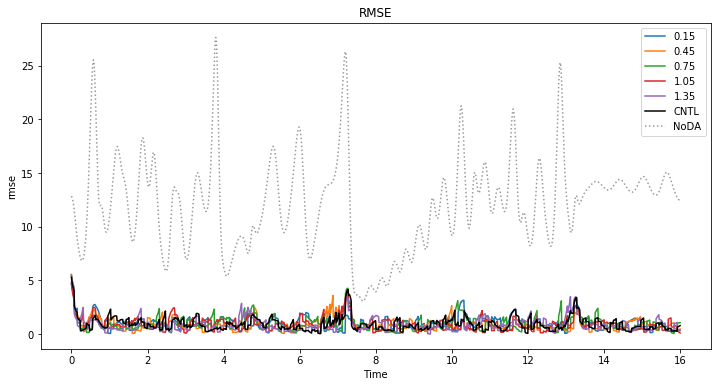

In [26]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_a in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_a]
    
    params = {
        'X_ini': X_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'Pb': Pb,
        'R': R, 
        'H_func': lambda arr: arr,
        'H': np.eye(3)
    }

    oi = OI(lorenz63_fdm, dt)
    oi.set_params(**params)
    oi.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(oi.analysis, X_nature)
    print(
        f'alpha={ex_a}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_a)
    
# CNTL
plt.plot(ts, rmse_oi, color='k', label='CNTL')
    
# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
plt.legend()
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

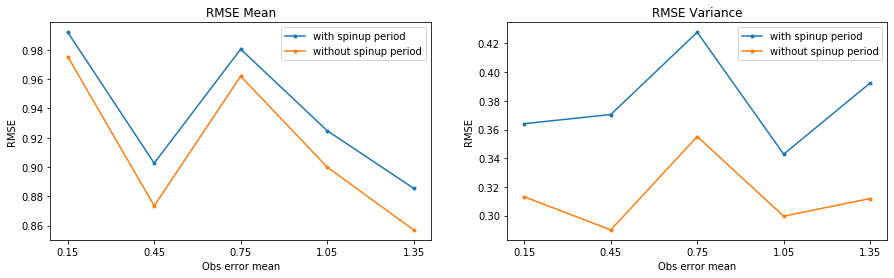

In [27]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_alpha = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_alpha, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_alpha, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(ex_alpha)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_alpha, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_alpha, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(ex_alpha)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

### Assimilate more extreme skewness

In [28]:
ex_obs_dict = pickle.load(open('./data/obs_skew_130_330.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['1.30', '1.55', '1.80', '2.05', '2.30', '2.55', '2.80', '3.05', '3.30'])

alpha=1.30, Mean RMSE=1.0910, Variance RMSE=0.4883,  Without spinup: Mean RMSE=1.0551, Variance RMSE=0.4115
alpha=1.55, Mean RMSE=0.8335, Variance RMSE=0.3396,  Without spinup: Mean RMSE=0.8126, Variance RMSE=0.2439
alpha=1.80, Mean RMSE=0.8946, Variance RMSE=0.3837,  Without spinup: Mean RMSE=0.8665, Variance RMSE=0.3215
alpha=2.05, Mean RMSE=0.9402, Variance RMSE=0.3737,  Without spinup: Mean RMSE=0.9155, Variance RMSE=0.3049
alpha=2.30, Mean RMSE=0.9903, Variance RMSE=0.4349,  Without spinup: Mean RMSE=0.9600, Variance RMSE=0.3341
alpha=2.55, Mean RMSE=0.9298, Variance RMSE=0.3544,  Without spinup: Mean RMSE=0.9148, Variance RMSE=0.3129
alpha=2.80, Mean RMSE=0.9454, Variance RMSE=0.3691,  Without spinup: Mean RMSE=0.9253, Variance RMSE=0.3170
alpha=3.05, Mean RMSE=0.9809, Variance RMSE=0.3525,  Without spinup: Mean RMSE=0.9648, Variance RMSE=0.2784
alpha=3.30, Mean RMSE=0.9143, Variance RMSE=0.3714,  Without spinup: Mean RMSE=0.8960, Variance RMSE=0.3150


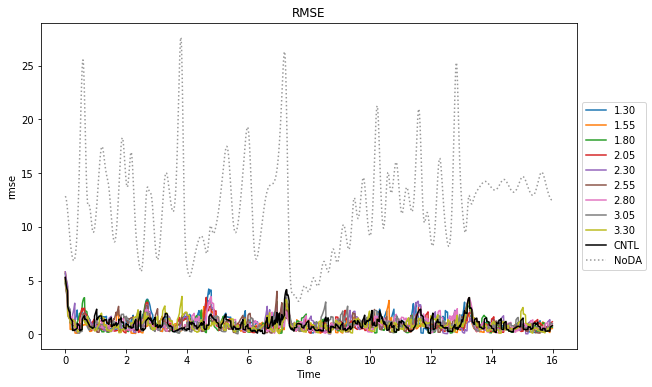

In [29]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_a in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_a]
    
    params = {
        'X_ini': X_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'Pb': Pb,
        'R': R, 
        'H_func': lambda arr: arr,
        'H': np.eye(3)
    }

    oi = OI(lorenz63_fdm, dt)
    oi.set_params(**params)
    oi.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(oi.analysis, X_nature)
    print(
        f'alpha={ex_a}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_a)
    
# CNTL
plt.plot(ts, rmse_oi, color='k', label='CNTL')
    
# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

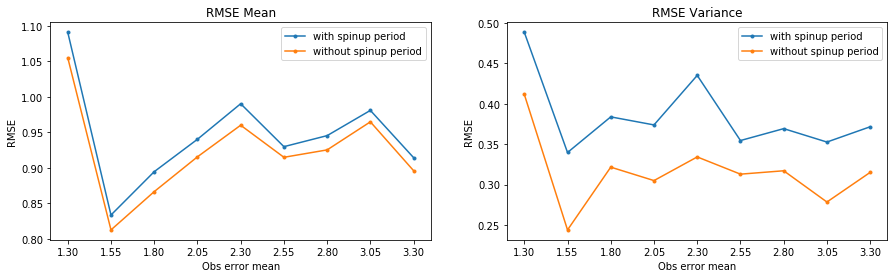

In [30]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_alpha = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_alpha, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_alpha, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(ex_alpha)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_alpha, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_alpha, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(ex_alpha)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

### Repeated assimilate skew observation based on normality test (repeat 10 times)

In [31]:
ex_obs_dict = pickle.load(open('./data/obs_skew_015_135.pickle', 'rb'))
ex_alpha = ex_obs_dict.keys()
ex_alpha = list(map(float, ex_alpha))
ex_alpha

[0.15, 0.45, 0.75, 1.05, 1.35]

In [32]:
from gen_skew_func import gen_skew_obs

rmse_dict = {}
for ex_a in ex_alpha:
    print(ex_a)
    rmse = np.zeros_like(ts)
    
    for _ in range(10):
        obs = gen_skew_obs(mean=0, var=2, alpha=ex_a, obs_intv=8)
        
        params = {
            'X_ini': X_ini, 
            'obs': obs, 
            'obs_interv': 8, 
            'Pb': Pb,
            'R': R, 
            'H_func': lambda arr: arr,
            'H': np.eye(3)
        }

        oi = OI(lorenz63_fdm, dt)
        oi.set_params(**params)
        oi.cycle()
        rmse += RMSE(oi.analysis, X_nature)

    rmse /= 10
    key = f'{ex_a:.2f}'
    rmse_dict[key] = rmse

0.15
0.45
0.75
1.05
1.35


alpha = 0.15, mean RMSE = 0.9333
alpha = 0.45, mean RMSE = 0.9446
alpha = 0.75, mean RMSE = 0.9595
alpha = 1.05, mean RMSE = 0.9241
alpha = 1.35, mean RMSE = 0.9699


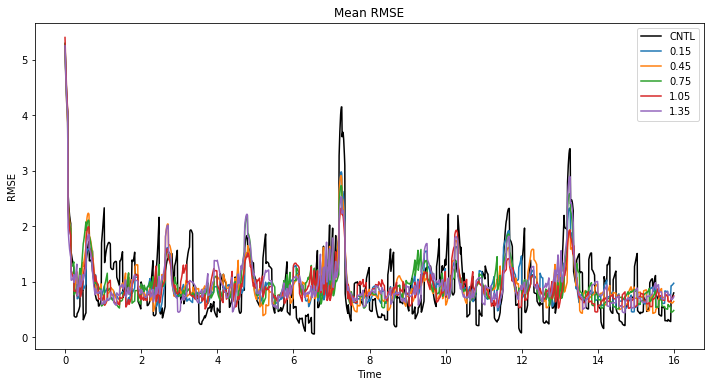

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(ts, rmse_oi, 'k', label='CNTL')

for key, rmse in rmse_dict.items():
    print(f'alpha = {key}, mean RMSE = {rmse.mean():.4f}')
    plt.plot(ts, rmse, label=key)

plt.legend()
plt.title('Mean RMSE')
plt.xlabel('Time')
plt.ylabel('RMSE');

### Repeated assimilate skew observations for more extreme alpha (repeat 10 times)

In [34]:
ex_obs_dict = pickle.load(open('./data/obs_skew_130_330.pickle', 'rb'))
ex_alpha = ex_obs_dict.keys()
ex_alpha = list(map(float, ex_alpha))
ex_alpha

[1.3, 1.55, 1.8, 2.05, 2.3, 2.55, 2.8, 3.05, 3.3]

In [36]:
from gen_skew_func import gen_skew_obs

rmse_dict = {}
for ex_a in ex_alpha:
    print(ex_a)
    rmse = np.zeros_like(ts)
    
    for _ in range(10):
        obs = gen_skew_obs(mean=0, var=2, alpha=ex_a, obs_intv=8)
        
        params = {
            'X_ini': X_ini, 
            'obs': obs, 
            'obs_interv': 8, 
            'Pb': Pb,
            'R': R, 
            'H_func': lambda arr: arr,
            'H': np.eye(3)
        }

        oi = OI(lorenz63_fdm, dt)
        oi.set_params(**params)
        oi.cycle()
        rmse += RMSE(oi.analysis, X_nature)

    rmse /= 10
    key = f'{ex_a:.2f}'
    rmse_dict[key] = rmse

1.3
1.55
1.8
2.05
2.3
2.55
2.8
3.05
3.3


alpha = 1.30, mean RMSE = 0.9481
alpha = 1.55, mean RMSE = 0.9714
alpha = 1.80, mean RMSE = 0.9376
alpha = 2.05, mean RMSE = 0.9210
alpha = 2.30, mean RMSE = 0.9774
alpha = 2.55, mean RMSE = 0.9174
alpha = 2.80, mean RMSE = 0.9390
alpha = 3.05, mean RMSE = 0.9407
alpha = 3.30, mean RMSE = 0.9248


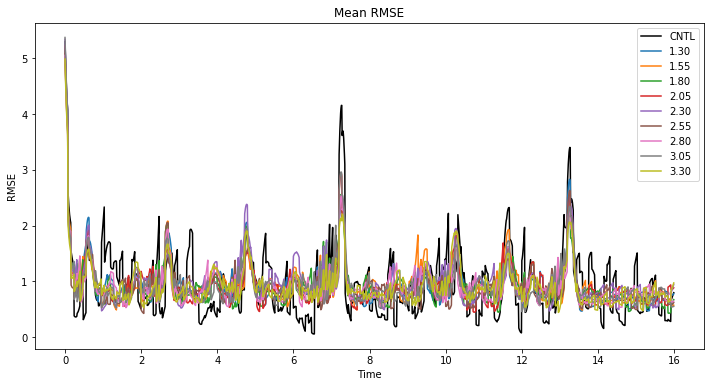

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(ts, rmse_oi, 'k', label='CNTL')

for key, rmse in rmse_dict.items():
    print(f'alpha = {key}, mean RMSE = {rmse.mean():.4f}')
    plt.plot(ts, rmse, label=key)

plt.legend()
plt.title('Mean RMSE')
plt.xlabel('Time')
plt.ylabel('RMSE');

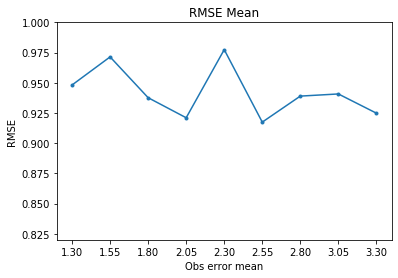

In [39]:
mean_rmse = []
for key, rmse in rmse_dict.items():
    mean_rmse.append(rmse.mean())


plt.plot(ex_alpha, mean_rmse, '.-')
plt.title('RMSE Mean')
plt.xticks(ex_alpha)
plt.xlabel('Obs error mean')
plt.ylabel('RMSE')
plt.ylim([0.82, 1]);

### Check the ratio of skew observation located between -2*std ~ 2*std

In [40]:
ex_obs_dict = pickle.load(open('./data/obs_skew_130_330.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['1.30', '1.55', '1.80', '2.05', '2.30', '2.55', '2.80', '3.05', '3.30'])

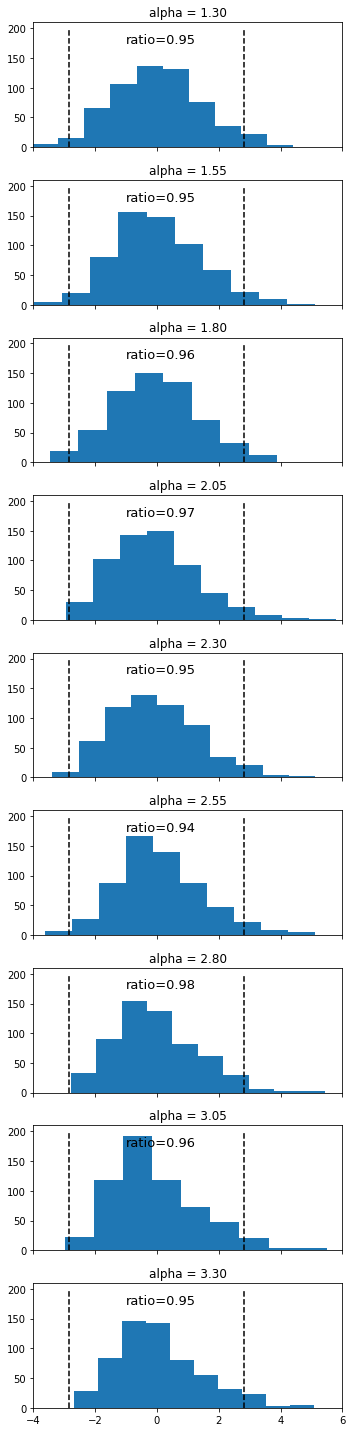

In [41]:
nrows = len(ex_obs_dict.keys())
fig, axs = plt.subplots(nrows=nrows, figsize=(5, 20), sharex=True)

for i, (key, obs) in enumerate(ex_obs_dict.items()):
    obserr = (obs - X_nature[:,::8]).ravel()
    axs[i].hist(obserr)
    
    std = np.sqrt(2)
    axs[i].vlines([2*std, -2*std], ymin=0, ymax=200, ls='dashed')
    axs[i].set_xlim([-4, 6])
    axs[i].set_title(f'alpha = {key}')
    
    total_size = obserr.size
    within_size = obserr[np.where((obserr <= 2*std) & (obserr >= -2*std))].size
    ratio = within_size / total_size
    axs[i].text(-1, 175, f'ratio={ratio:.2f}', fontsize=13)

plt.tight_layout()

# Fourth moment

### Assimilate kurtosis observation based on normality test

In [42]:
ex_obs_dict = pickle.load(open('./data/obs_kurtosis_050_220.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.5', '0.6', '0.7', '0.8', '0.9', '1.2', '1.6', '1.8', '2.0', '2.2'])

delta=0.5, Mean RMSE=1.0396, Variance RMSE=0.5601,  Without spinup: Mean RMSE=1.0074, Variance RMSE=0.4880
delta=0.6, Mean RMSE=0.9003, Variance RMSE=0.3110,  Without spinup: Mean RMSE=0.8740, Variance RMSE=0.2464
delta=0.7, Mean RMSE=0.9278, Variance RMSE=0.3790,  Without spinup: Mean RMSE=0.9034, Variance RMSE=0.2939
delta=0.8, Mean RMSE=0.9389, Variance RMSE=0.3232,  Without spinup: Mean RMSE=0.9216, Variance RMSE=0.2427
delta=0.9, Mean RMSE=0.9553, Variance RMSE=0.3721,  Without spinup: Mean RMSE=0.9314, Variance RMSE=0.2815
delta=1.2, Mean RMSE=0.9952, Variance RMSE=0.4398,  Without spinup: Mean RMSE=0.9692, Variance RMSE=0.3875
delta=1.6, Mean RMSE=0.8822, Variance RMSE=0.2734,  Without spinup: Mean RMSE=0.8545, Variance RMSE=0.2038
delta=1.8, Mean RMSE=1.0332, Variance RMSE=0.4330,  Without spinup: Mean RMSE=1.0133, Variance RMSE=0.3817
delta=2.0, Mean RMSE=0.9492, Variance RMSE=0.2966,  Without spinup: Mean RMSE=0.9284, Variance RMSE=0.2518
delta=2.2, Mean RMSE=0.9411, Variance

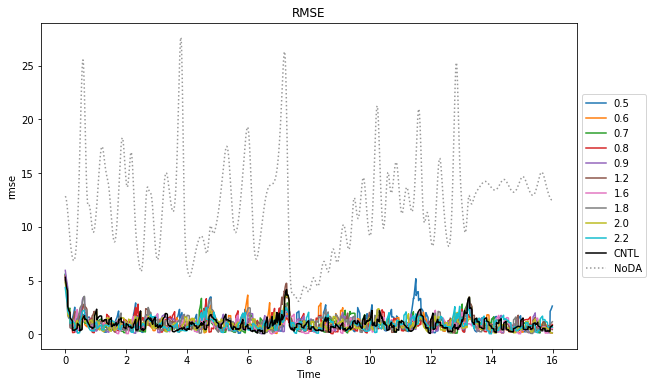

In [43]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_d in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_d]
    
    params = {
        'X_ini': X_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'Pb': Pb,
        'R': R, 
        'H_func': lambda arr: arr,
        'H': np.eye(3)
    }

    oi = OI(lorenz63_fdm, dt)
    oi.set_params(**params)
    oi.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(oi.analysis, X_nature)
    print(
        f'delta={ex_d}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_d)
    
# CNTL
plt.plot(ts, rmse_oi, color='k', label='CNTL')
    
# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

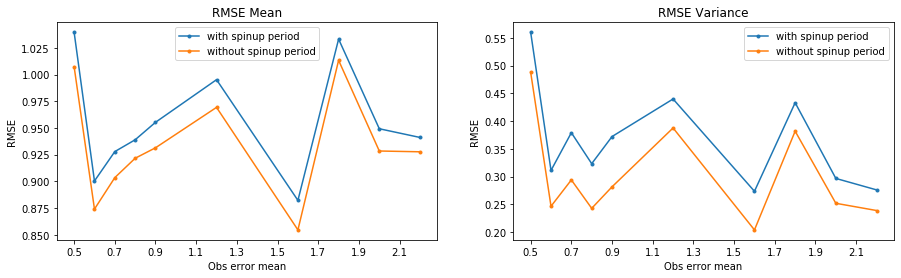

In [44]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_delta = list(map(lambda s: float(s), ex_obs_dict.keys()))
xticks = np.arange(min(ex_delta), max(ex_delta), 0.2)

axs[0].plot(ex_delta, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_delta, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(xticks)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_delta, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_delta, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(xticks)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

(-20, 20)

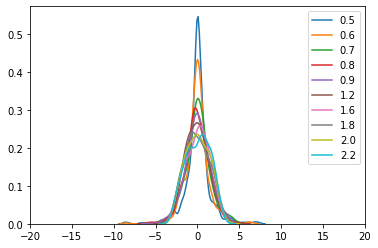

In [45]:
import seaborn as sns

fig, ax = plt.subplots()

for key in ex_obs_dict.keys():
    obs = ex_obs_dict[key]
    obserr = obs - X_nature[:,::8]
    obserr = obserr.ravel()
    sns.kdeplot(obserr, label=key, ax=ax)
plt.xlim([-20, 20])

### Assimilate kurtosis observation with more extreme delta

In [46]:
ex_obs_dict = pickle.load(open('./data/obs_kurtosis_010_340.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.1', '0.2', '0.3', '0.4', '2.5', '2.8', '3.1', '3.4'])

delta=0.1, Mean RMSE=0.6356, Variance RMSE=0.8448,  Without spinup: Mean RMSE=0.6109, Variance RMSE=0.7859
delta=0.2, Mean RMSE=0.7713, Variance RMSE=0.7370,  Without spinup: Mean RMSE=0.7504, Variance RMSE=0.6768
delta=0.3, Mean RMSE=0.8660, Variance RMSE=0.7378,  Without spinup: Mean RMSE=0.8399, Variance RMSE=0.6838
delta=0.4, Mean RMSE=0.8484, Variance RMSE=0.3704,  Without spinup: Mean RMSE=0.8183, Variance RMSE=0.2866
delta=2.5, Mean RMSE=0.9426, Variance RMSE=0.3849,  Without spinup: Mean RMSE=0.9231, Variance RMSE=0.3174
delta=2.8, Mean RMSE=0.9253, Variance RMSE=0.3573,  Without spinup: Mean RMSE=0.9145, Variance RMSE=0.3257
delta=3.1, Mean RMSE=0.9301, Variance RMSE=0.3333,  Without spinup: Mean RMSE=0.9011, Variance RMSE=0.2871
delta=3.4, Mean RMSE=0.9273, Variance RMSE=0.2781,  Without spinup: Mean RMSE=0.9006, Variance RMSE=0.2244


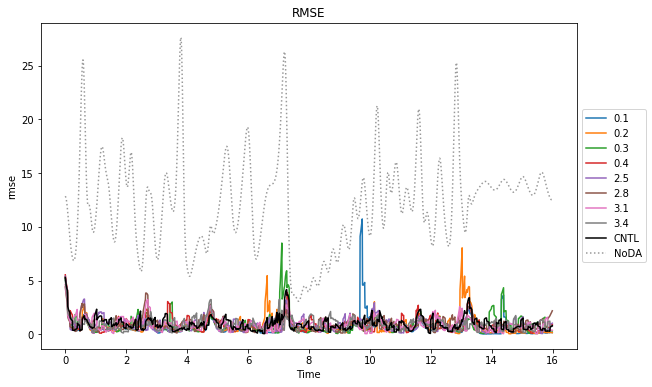

In [47]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_d in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_d]
    
    params = {
        'X_ini': X_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'Pb': Pb,
        'R': R, 
        'H_func': lambda arr: arr,
        'H': np.eye(3)
    }

    oi = OI(lorenz63_fdm, dt)
    oi.set_params(**params)
    oi.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(oi.analysis, X_nature)
    print(
        f'delta={ex_d}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_d)
    
# CNTL
plt.plot(ts, rmse_oi, color='k', label='CNTL')
    
# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

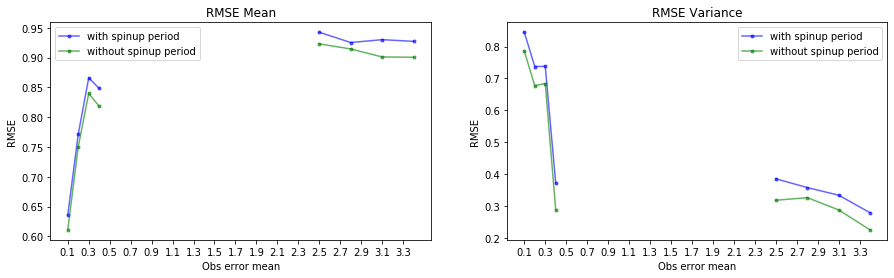

In [48]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_delta = list(map(lambda s: float(s), ex_obs_dict.keys()))
xticks = np.arange(min(ex_delta), max(ex_delta), 0.2)

axs[0].plot(ex_delta[:4], mean_rmse[:4], 'b.-', alpha=0.6, label='with spinup period')
axs[0].plot(ex_delta[4:], mean_rmse[4:], 'b.-', alpha=0.6)
axs[0].plot(ex_delta[:4], mean_rmse_nospn[:4], 'g.-', alpha=0.6, label='without spinup period')
axs[0].plot(ex_delta[4:], mean_rmse_nospn[4:], 'g.-', alpha=0.6)
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(xticks)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_delta[:4], var_rmse[:4], 'b.-', alpha=0.6, label='with spinup period')
axs[1].plot(ex_delta[4:], var_rmse[4:], 'b.-', alpha=0.6)
axs[1].plot(ex_delta[:4], var_rmse_nospn[:4], 'g.-', alpha=0.6, label='without spinup period')
axs[1].plot(ex_delta[4:], var_rmse_nospn[4:], 'g.-', alpha=0.6)
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(xticks)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

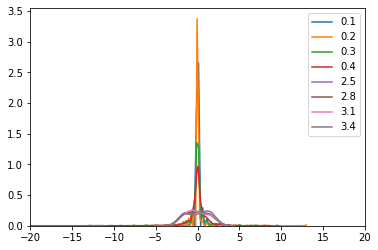

In [49]:
fig, ax = plt.subplots()

for key in ex_obs_dict.keys():
    obs = ex_obs_dict[key]
    obserr = obs - X_nature[:,::8]
    obserr = obserr.ravel()
    sns.kdeplot(obserr, label=key, ax=ax)
plt.xlim([-20, 20]);